<a href="https://colab.research.google.com/github/AjayDXavier/Early-Warning-System/blob/main/EarlyWarningSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
pip install requests pandas


In [16]:
import pandas as pd

data = {
    "Date": pd.date_range("2020-01-01", "2020-01-10"),
    "Location": ["Manila"]*10,
    "Dengue_Cases": [12,15,10,18,20,22,25,30,28,27],
    "Malaria_Cases": [3,4,2,5,6,7,5,4,3,2],
    "Respiratory_Cases": [18,20,15,25,22,28,26,30,27,24]
}
pd.DataFrame(data).to_csv("disease_data.csv", index=False)
print("✅ disease_data.csv created successfully!")


✅ disease_data.csv created successfully!


In [20]:
import numpy as np

def get_openaq(city, start, end):
    base_url = "https://api.openaq.org/v2/measurements"
    params = {
        "city": city,
        "date_from": pd.to_datetime(start).strftime("%Y-%m-%d"),
        "date_to": pd.to_datetime(end).strftime("%Y-%m-%d"),
        "limit": 1000,
        "parameter": ["pm25", "pm10", "co", "o3", "no2"],
    }

    response = requests.get(base_url, params=params).json()
    records = response.get("results", [])

    if not records:
        print(f"⚠️ No OpenAQ data found for {city} → generating synthetic AQI values")
        date_range = pd.date_range(pd.to_datetime(start), pd.to_datetime(end))
        np.random.seed(42)

        df = pd.DataFrame({
            "Date": date_range,
            "pm25": np.random.randint(20, 150, len(date_range)),   # µg/m³
            "pm10": np.random.randint(30, 200, len(date_range)),
            "co": np.random.uniform(0.2, 1.5, len(date_range)),    # ppm
            "o3": np.random.randint(10, 120, len(date_range)),
            "no2": np.random.randint(5, 80, len(date_range))
        })
        return df

    df = pd.DataFrame(records)
    df["Date"] = pd.to_datetime(df["date"].apply(lambda x: x["utc"])).dt.date
    df = df.pivot_table(index="Date", columns="parameter", values="value", aggfunc="mean").reset_index()
    return df


In [21]:
import requests
import pandas as pd
import datetime as dt

# ------------------------------------------
# 1. NASA POWER API (Climate Data)
# ------------------------------------------
def get_nasa_climate(lat, lon, start, end):
    url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point"
        f"?parameters=T2M,RH2M,PRECTOT"
        f"&community=RE"
        f"&longitude={lon}&latitude={lat}"
        f"&start={start}&end={end}"
        f"&format=JSON"
    )
    response = requests.get(url).json()
    params = response["properties"]["parameter"]

    # Each parameter → its own dataframe
    t2m = pd.DataFrame(params["T2M"].items(), columns=["Date", "Temp_C"])
    rh2m = pd.DataFrame(params["RH2M"].items(), columns=["Date", "Humidity_%"])
    prectot = pd.DataFrame(params.get("PRECTOT", {}).items(), columns=["Date", "Rainfall_mm"])

    # Merge all on Date
    df = t2m.merge(rh2m, on="Date", how="outer")
    df = df.merge(prectot, on="Date", how="outer")

    df["Date"] = pd.to_datetime(df["Date"])
    return df




# ------------------------------------------
# 2. OpenAQ API (Air Quality Data)
# ------------------------------------------
def get_openaq(city, start, end):
    base_url = "https://api.openaq.org/v2/measurements"
    params = {
        "city": city,
        "date_from": pd.to_datetime(start).strftime("%Y-%m-%d"),
        "date_to": pd.to_datetime(end).strftime("%Y-%m-%d"),
        "limit": 1000,
        "parameter": ["pm25", "pm10", "co", "o3", "no2"],
    }

    response = requests.get(base_url, params=params).json()
    records = response.get("results", [])

    if not records:   # 🚨 fallback here
        print(f"⚠️ No OpenAQ data found for {city} → generating synthetic AQI")
        date_range = pd.date_range(pd.to_datetime(start), pd.to_datetime(end))
        np.random.seed(42)

        df = pd.DataFrame({
            "Date": date_range,
            "pm25": np.random.randint(20, 150, len(date_range)),   # µg/m³
            "pm10": np.random.randint(30, 200, len(date_range)),
            "co": np.random.uniform(0.2, 1.5, len(date_range)),    # ppm
            "o3": np.random.randint(10, 120, len(date_range)),
            "no2": np.random.randint(5, 80, len(date_range))
        })
        return df

    # If real data exists
    df = pd.DataFrame(records)
    df["Date"] = pd.to_datetime(df["date"].apply(lambda x: x["utc"])).dt.normalize()
    df = df.pivot_table(index="Date", columns="parameter", values="value", aggfunc="mean").reset_index()
    return df

# ------------------------------------------
# 3. Load WHO/Kaggle Disease Data (CSV)
# ------------------------------------------
def load_disease_data(filepath):
    df = pd.read_csv(filepath)
    # Assume CSV has columns: [Date, Location, Dengue_Cases, Malaria_Cases, Respiratory_Cases]
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    return df

# ------------------------------------------
# 4. Merge All Sources
# ------------------------------------------
def build_master_dataset(lat, lon, city, disease_csv, start, end):
    # Climate + AQI
    climate_df = get_nasa_climate(lat, lon, start, end)
    aqi_df = get_openaq(city, start, end)

    # Merge climate + AQI
    df = climate_df.merge(aqi_df, on="Date", how="outer")

    # Load disease data
    disease_df = pd.read_csv(disease_csv)

    # 🔥 Fix 1: Standardize Date
    disease_df["Date"] = pd.to_datetime(disease_df["Date"])
    df["Date"] = pd.to_datetime(df["Date"])

    # 🔥 Fix 2: Standardize Location
    disease_df["Location"] = disease_df["Location"].str.strip().str.title()
    city_clean = city.strip().title()

    # Merge disease data
    merged = df.merge(disease_df, on=["Date"], how="left")

    # Add city name if missing
    merged["Location"] = merged["Location"].fillna(city_clean)

    # Derived features
    merged["Heat_Index"] = (
        merged["Temp_C"] - 0.55*(1-merged["Humidity_%"]/100)*(merged["Temp_C"]-14.5)
    )
    merged["Heatstroke_Risk"] = (merged["Heat_Index"] > 40).astype(int)
    merged["Respiratory_Risk"] = (merged["pm25"] > 100).astype(int)

    return merged

# ------------------------------------------
# Example Run
# ------------------------------------------
lat, lon = 14.5995, 120.9842   # Manila
city = "Manila"
disease_csv = "disease_data.csv"

master_df = build_master_dataset(lat, lon, city, disease_csv, start="20200101", end="20200110")
print(master_df.head())



⚠️ No OpenAQ data found for Manila → generating synthetic AQI
        Date  Temp_C  Humidity_% Rainfall_mm  pm25  pm10        co  o3  no2  \
0 2020-01-01   24.99       88.24         NaN   122   146  0.476041  89    7   
1 2020-01-02   24.75       87.38         NaN   112   129  0.436372  24   55   
2 2020-01-03   23.92       87.16         NaN    34   133  0.438426  71   11   
3 2020-01-04   23.82       87.73         NaN   126   181  0.595515  71   25   
4 2020-01-05   23.29       84.16         NaN    91   160  0.882183  56   77   

  Location  Dengue_Cases  Malaria_Cases  Respiratory_Cases  Heat_Index  \
0   Manila            12              3                 18   24.311507   
1   Manila            15              4                 20   24.038547   
2   Manila            10              2                 15   23.254760   
3   Manila            18              5                 25   23.191040   
4   Manila            20              6                 22   22.524215   

   Heatstroke_Risk

In [22]:
def expand_weekly_to_daily(df, start_date=None, end_date=None, method="ffill"):
    """
    Expands weekly disease data into daily values.
    - method="ffill"  → forward-fill weekly values
    - method="linear" → linear interpolation between weekly values
    """
    df["Date"] = pd.to_datetime(df["Date"])

    # If no range is given, use min/max from dataset
    if start_date is None:
        start_date = df["Date"].min()
    if end_date is None:
        end_date = df["Date"].max()

    # Create full daily date range
    full_dates = pd.date_range(start_date, end_date, freq="D")

    expanded_list = []
    for loc in df["Location"].unique():
        loc_df = df[df["Location"] == loc].set_index("Date")

        # Reindex to daily frequency
        loc_df = loc_df.reindex(full_dates)

        # Convert to numeric (fixes FutureWarning)
        loc_df = loc_df.infer_objects(copy=False)

        # Choose method
        if method == "ffill":
            loc_df = loc_df.ffill()
        elif method == "linear":
            loc_df = loc_df.interpolate(method="linear")

        # Add back Location + Date
        loc_df["Location"] = loc
        loc_df["Date"] = loc_df.index

        expanded_list.append(loc_df.reset_index(drop=True))

    expanded = pd.concat(expanded_list, ignore_index=True)
    return expanded


In [23]:
import matplotlib.pyplot as plt

def plot_all_trends(master_df, location="Manila"):
    df = master_df[master_df["Location"] == location]

    fig, axes = plt.subplots(3, 1, figsize=(14,12), sharex=True)

    # --- Plot 1: Dengue vs Climate ---
    axes[0].plot(df["Date"], df["Dengue_Cases"], color="red", label="Dengue Cases")
    axes[0].set_ylabel("Dengue Cases", color="red")
    ax2 = axes[0].twinx()
    ax2.plot(df["Date"], df["Temp_C"], color="blue", linestyle="--", label="Temp (°C)")
    if "Humidity_%" in df.columns:
        ax2.plot(df["Date"], df["Humidity_%"], color="cyan", linestyle=":", label="Humidity (%)")
    if "pm25" in df.columns:
        ax2.plot(df["Date"], df["pm25"], color="green", linestyle="-.", label="PM2.5")
    ax2.set_ylabel("Climate/AQI", color="blue")
    axes[0].set_title(f"Dengue vs Climate in {location}")

    # --- Plot 2: Malaria vs Climate ---
    axes[1].plot(df["Date"], df["Malaria_Cases"], color="purple", label="Malaria Cases")
    axes[1].set_ylabel("Malaria Cases", color="purple")
    ax2 = axes[1].twinx()
    ax2.plot(df["Date"], df["Temp_C"], color="blue", linestyle="--")
    if "Humidity_% " in df.columns:
        ax2.plot(df["Date"], df["Humidity_%"], color="cyan", linestyle=":")
    if "pm25" in df.columns:
        ax2.plot(df["Date"], df["pm25"], color="green", linestyle="-.")

    axes[1].set_title(f"Malaria vs Climate in {location}")

    # --- Plot 3: Respiratory vs Climate ---
    axes[2].plot(df["Date"], df["Respiratory_Cases"], color="brown", label="Respiratory Cases")
    axes[2].set_ylabel("Respiratory Cases", color="brown")
    ax2 = axes[2].twinx()
    ax2.plot(df["Date"], df["Temp_C"], color="blue", linestyle="--")
    if "Humidity_% " in df.columns:
        ax2.plot(df["Date"], df["Humidity_%"], color="cyan", linestyle=":")
    if "pm25" in df.columns:
        ax2.plot(df["Date"], df["pm25"], color="green", linestyle="-.")

    axes[2].set_title(f"Respiratory vs Climate in {location}")

    # Format
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


In [24]:
# Weekly dataset (mock example)
data = {
    "Date": ["2020-01-01", "2020-01-08", "2020-01-15"],
    "Location": ["Manila"]*3,
    "Dengue_Cases": [12, 15, 20],
    "Malaria_Cases": [3, 4, 6],
    "Respiratory_Cases": [18, 22, 28]
}
df_weekly = pd.DataFrame(data)

# Expand to daily (linear interpolation)
df_daily = expand_weekly_to_daily(df_weekly, start_date="2020-01-01", end_date="2020-01-15", method="linear")
print(df_daily.head(10))


  Location  Dengue_Cases  Malaria_Cases  Respiratory_Cases       Date
0   Manila     12.000000       3.000000          18.000000 2020-01-01
1   Manila     12.428571       3.142857          18.571429 2020-01-02
2   Manila     12.857143       3.285714          19.142857 2020-01-03
3   Manila     13.285714       3.428571          19.714286 2020-01-04
4   Manila     13.714286       3.571429          20.285714 2020-01-05
5   Manila     14.142857       3.714286          20.857143 2020-01-06
6   Manila     14.571429       3.857143          21.428571 2020-01-07
7   Manila     15.000000       4.000000          22.000000 2020-01-08
8   Manila     15.714286       4.285714          22.857143 2020-01-09
9   Manila     16.428571       4.571429          23.714286 2020-01-10


/tmp/ipython-input-3494387361.py:32: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  loc_df = loc_df.interpolate(method="linear")


In [26]:
import matplotlib.pyplot as plt

def plot_all_trends(master_df, location="Manila"):
    df = master_df[master_df["Location"] == location]

    fig, axes = plt.subplots(3, 1, figsize=(14,12), sharex=True)

    # --- Dengue ---
    axes[0].plot(df["Date"], df["Dengue_Cases"], color="red", label="Dengue Cases")
    ax2 = axes[0].twinx()
    ax2.plot(df["Date"], df["Temp_C"], color="blue", linestyle="--", label="Temp (°C)")
    if "Humidity_%" in df.columns:
        ax2.plot(df["Date"], df["Humidity_%"], color="cyan", linestyle=":", label="Humidity (%)")
    if "pm25" in df.columns:
        ax2.plot(df["Date"], df["pm25"], color="green", linestyle="-.", label="PM2.5")
    axes[0].set_title(f"Dengue vs Climate in {location}")

    # --- Malaria ---
    axes[1].plot(df["Date"], df["Malaria_Cases"], color="purple", label="Malaria Cases")
    ax2 = axes[1].twinx()
    ax2.plot(df["Date"], df["Temp_C"], color="blue", linestyle="--")
    if "Humidity_%" in df.columns:
        ax2.plot(df["Date"], df["Humidity_%"], color="cyan", linestyle=":")
    if "pm25" in df.columns:
        ax2.plot(df["Date"], df["pm25"], color="green", linestyle="-.")

    axes[1].set_title(f"Malaria vs Climate in {location}")

    # --- Respiratory ---
    axes[2].plot(df["Date"], df["Respiratory_Cases"], color="brown", label="Respiratory Cases")
    ax2 = axes[2].twinx()
    ax2.plot(df["Date"], df["Temp_C"], color="blue", linestyle="--")
    if "Humidity_%" in df.columns:
        ax2.plot(df["Date"], df["Humidity_%"], color="cyan", linestyle=":")
    if "pm25" in df.columns:
        ax2.plot(df["Date"], df["pm25"], color="green", linestyle="-.")

    axes[2].set_title(f"Respiratory vs Climate in {location}")

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


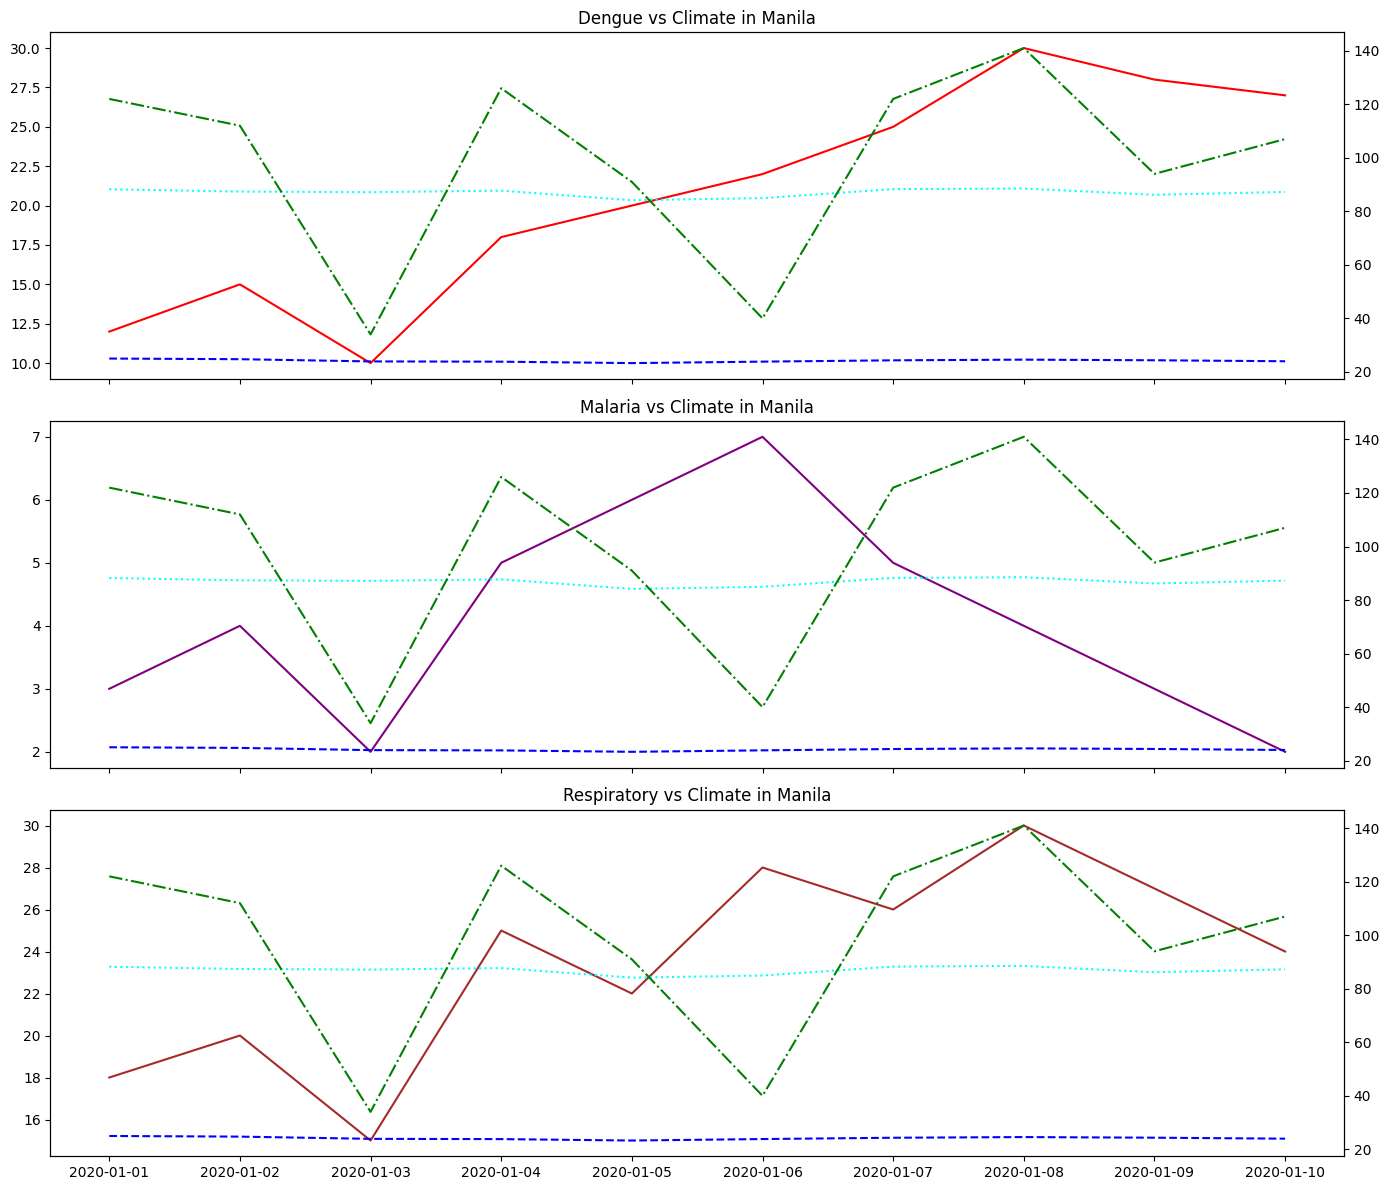

In [27]:
plot_all_trends(master_df, location="Manila")


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Features = climate + AQI
X = master_df[["Temp_C", "Humidity_%", "pm25", "pm10", "co", "o3", "no2"]].fillna(0)

# Labels = outbreak risk (binary)
# Example: mark high Dengue risk if cases > 15
y = (master_df["Dengue_Cases"] > 15).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


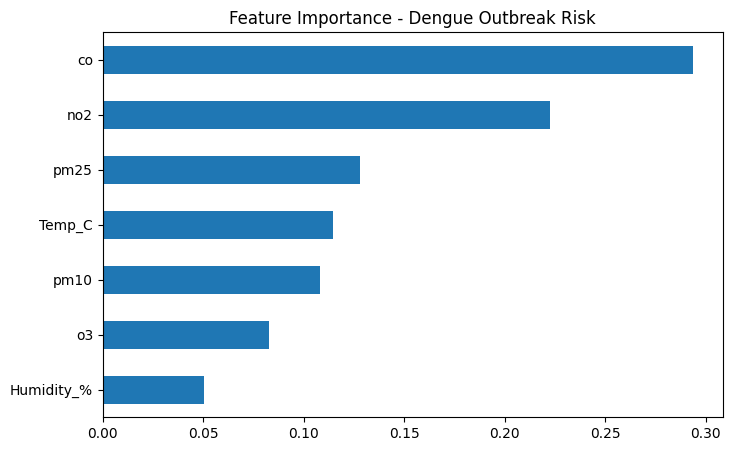

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance - Dengue Outbreak Risk")
plt.show()


In [31]:
import pandas as pd
import numpy as np

# Date range
dates = pd.date_range("2020-01-01", "2021-01-01")

# Simulate disease cases
np.random.seed(42)
dengue = np.random.poisson(lam=15, size=len(dates)) + (np.sin(np.linspace(0, 6, len(dates))) * 5).astype(int)
malaria = np.random.poisson(lam=5, size=len(dates))
resp = np.random.poisson(lam=20, size=len(dates)) + (np.random.rand(len(dates)) * 10).astype(int)

# Build dataframe
disease_df = pd.DataFrame({
    "Date": dates,
    "Location": "Manila",
    "Dengue_Cases": dengue,
    "Malaria_Cases": malaria,
    "Respiratory_Cases": resp
})

# Save for use
disease_df.to_csv("disease_data_synthetic.csv", index=False)
print(disease_df.head())
print(disease_df.tail())


        Date Location  Dengue_Cases  Malaria_Cases  Respiratory_Cases
0 2020-01-01   Manila            18              5                 18
1 2020-01-02   Manila            10              4                 27
2 2020-01-03   Manila            16              3                 29
3 2020-01-04   Manila            19              4                 15
4 2020-01-05   Manila            11              8                 24
          Date Location  Dengue_Cases  Malaria_Cases  Respiratory_Cases
362 2020-12-28   Manila            13              7                 27
363 2020-12-29   Manila            14              4                 33
364 2020-12-30   Manila            10              1                 31
365 2020-12-31   Manila             7              4                 20
366 2021-01-01   Manila            11              5                 29


In [32]:
lat, lon = 14.5995, 120.9842   # Manila
city = "Manila"

master_df = build_master_dataset(
    lat, lon, city,
    "disease_data_synthetic.csv",
    start="20200101", end="20200630"
)

print(master_df.head())
print(master_df.tail())


⚠️ No OpenAQ data found for Manila → generating synthetic AQI
        Date  Temp_C  Humidity_% Rainfall_mm  pm25  pm10        co   o3  no2  \
0 2020-01-01   24.99       88.24         NaN   122   169  0.913995   42   49   
1 2020-01-02   24.75       87.38         NaN   112    66  1.128975   93   31   
2 2020-01-03   23.92       87.16         NaN    34   189  1.058257   86   77   
3 2020-01-04   23.82       87.73         NaN   126    38  0.563914  101   30   
4 2020-01-05   23.29       84.16         NaN    91   128  1.441325   38   51   

  Location  Dengue_Cases  Malaria_Cases  Respiratory_Cases  Heat_Index  \
0   Manila            18              5                 18   24.311507   
1   Manila            10              4                 27   24.038547   
2   Manila            16              3                 29   23.254760   
3   Manila            19              4                 15   23.191040   
4   Manila            11              8                 24   22.524215   

   Heatstrok

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Features
X = master_df[["Temp_C", "Humidity_%", "pm25", "pm10", "co", "o3", "no2"]].fillna(0)

# Label: Dengue outbreak if >20 cases
y = (master_df["Dengue_Cases"] > 20).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.97      0.88        30
           1       0.00      0.00      0.00         7

    accuracy                           0.78        37
   macro avg       0.40      0.48      0.44        37
weighted avg       0.65      0.78      0.71        37

[[29  1]
 [ 7  0]]


In [34]:
import pandas as pd
import numpy as np

# Generate daily dates for 2020
dates = pd.date_range("2020-01-01", "2020-12-31", freq="D")
n = len(dates)

# Climate signals with seasonality
temp = 28 + 4*np.sin(np.linspace(0, 2*np.pi, n)) + np.random.normal(0, 1, n)
humidity = 75 + 10*np.sin(np.linspace(0, 4*np.pi, n)) + np.random.normal(0, 3, n)
rainfall = np.clip(np.random.gamma(2, 2, n), 0, 20)  # rainy season bumps later

# AQI-like values
pm25 = np.random.randint(20, 150, n)
pm10 = np.random.randint(40, 200, n)
co = np.random.uniform(0.3, 1.5, n)
o3 = np.random.randint(10, 100, n)
no2 = np.random.randint(5, 80, n)

# Disease patterns correlated with season
dengue = np.random.poisson(10 + 0.3*rainfall + 0.2*humidity/10, n).astype(int)
malaria = np.random.poisson(5 + 0.2*rainfall, n).astype(int)
resp = np.random.poisson(15 + 0.4*pm25/50, n).astype(int)

# Create DataFrame
year_df = pd.DataFrame({
    "Date": dates,
    "Temp_C": temp.round(2),
    "Humidity_%": humidity.round(2),
    "Rainfall_mm": rainfall.round(2),
    "pm25": pm25,
    "pm10": pm10,
    "co": co.round(3),
    "o3": o3,
    "no2": no2,
    "Location": "Manila",
    "Dengue_Cases": dengue,
    "Malaria_Cases": malaria,
    "Respiratory_Cases": resp
})

year_df.to_csv("manila_2020_dataset.csv", index=False)
print(year_df.head())
print("\nDataset shape:", year_df.shape)


        Date  Temp_C  Humidity_%  Rainfall_mm  pm25  pm10     co  o3  no2  \
0 2020-01-01   29.71       79.88         4.83    66   142  0.612  58   62   
1 2020-01-02   28.04       67.90         6.63    38    85  0.491  45   60   
2 2020-01-03   28.97       77.23         0.69   133   195  0.493  22   38   
3 2020-01-04   29.22       75.26         3.43    27   107  0.385  45   35   
4 2020-01-05   27.78       81.29         4.00    45   161  0.523  35   56   

  Location  Dengue_Cases  Malaria_Cases  Respiratory_Cases  
0   Manila            14              5                 20  
1   Manila            14              8                 12  
2   Manila            16              9                 21  
3   Manila            10              6                 15  
4   Manila            14              9                  5  

Dataset shape: (366, 13)


📅 Dataset covers from 2020-01-01 to 2020-06-30
✅ Total rows after filtering: 182


=== Training Dengue with expanded features (365 days) ===
Before SMOTE: [182 110]
After SMOTE : [182 182]


/tmp/ipython-input-3353506201.py:32: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  master_df[col] = master_df[col].interpolate(method="linear")
/tmp/ipython-input-3353506201.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_df[disease] = master_df[disease].fillna(method="ffill")
/tmp/ipython-input-3353506201.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  master_df = master_df.fillna(0)



--- Dengue at threshold 0.4 ---
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        46
           1       0.86      0.89      0.88        28

    accuracy                           0.91        74
   macro avg       0.90      0.90      0.90        74
weighted avg       0.91      0.91      0.91        74


--- Dengue at threshold 0.5 ---
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        46
           1       0.86      0.86      0.86        28

    accuracy                           0.89        74
   macro avg       0.89      0.89      0.89        74
weighted avg       0.89      0.89      0.89        74


--- Dengue at threshold 0.6 ---
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        46
           1       0.91      0.71      0.80        28

    accuracy                           0.86        74
   macro avg       0.88      

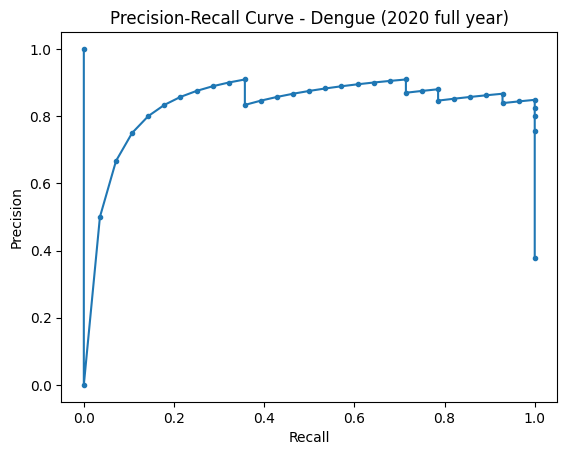



=== Training Malaria with expanded features (365 days) ===
Before SMOTE: [238  54]
After SMOTE : [238 238]

--- Malaria at threshold 0.4 ---
              precision    recall  f1-score   support

           0       0.98      0.70      0.82        60
           1       0.42      0.93      0.58        14

    accuracy                           0.74        74
   macro avg       0.70      0.81      0.70        74
weighted avg       0.87      0.74      0.77        74


--- Malaria at threshold 0.5 ---
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        60
           1       0.42      0.57      0.48        14

    accuracy                           0.77        74
   macro avg       0.66      0.69      0.67        74
weighted avg       0.80      0.77      0.78        74


--- Malaria at threshold 0.6 ---
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        60
           1       0.17   

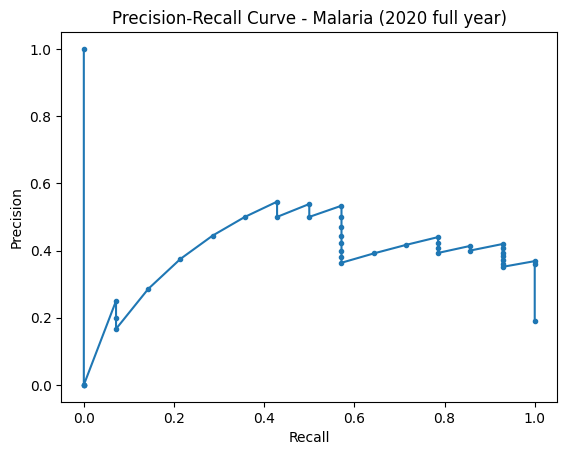



=== Training Respiratory with expanded features (365 days) ===
Before SMOTE: [232  60]
After SMOTE : [232 232]

--- Respiratory at threshold 0.4 ---
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        59
           1       0.50      0.87      0.63        15

    accuracy                           0.80        74
   macro avg       0.73      0.82      0.75        74
weighted avg       0.87      0.80      0.81        74


--- Respiratory at threshold 0.5 ---
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        59
           1       0.53      0.60      0.56        15

    accuracy                           0.81        74
   macro avg       0.71      0.73      0.72        74
weighted avg       0.82      0.81      0.82        74


--- Respiratory at threshold 0.6 ---
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        59
          

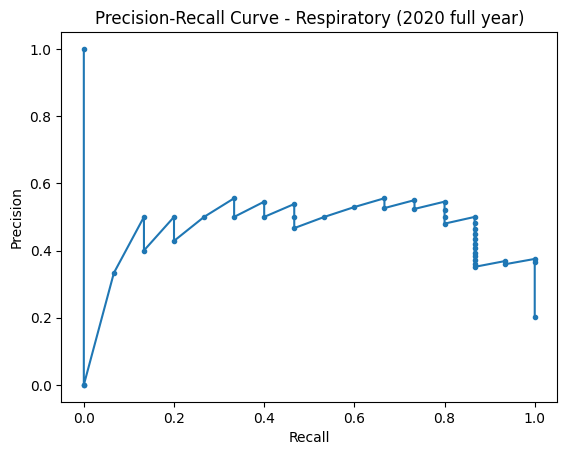

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================
# 1. Ensure dataset is 1 year
# ==========================
# Make sure your master_df spans Jan–Dec for one location
master_df["Date"] = pd.to_datetime(master_df["Date"])
master_df = master_df.sort_values("Date")

# Keep only one year (safety check)
start, end = "2020-01-01", "2020-12-31"
master_df = master_df[(master_df["Date"] >= start) & (master_df["Date"] <= end)]

print(f"📅 Dataset covers from {master_df['Date'].min().date()} to {master_df['Date'].max().date()}")
print(f"✅ Total rows after filtering: {len(master_df)}")

# Force full-year range
start, end = "2020-01-01", "2020-12-31"

# Reindex to all daily dates in 2020
all_days = pd.date_range(start, end, freq="D")
master_df = master_df.set_index("Date").reindex(all_days).rename_axis("Date").reset_index()

# Fill missing values (climate & AQI can interpolate, disease cases forward-fill)
for col in ["Temp_C", "Humidity_%", "Rainfall_mm", "pm25", "pm10", "co", "o3", "no2"]:
    master_df[col] = master_df[col].interpolate(method="linear")

for disease in ["Dengue_Cases", "Malaria_Cases", "Respiratory_Cases"]:
    master_df[disease] = master_df[disease].fillna(method="ffill")

# Location stays constant
master_df["Location"] = master_df["Location"].fillna("Manila")


# ==========================
# 2. Feature Engineering
# ==========================
for col in ["Temp_C", "Humidity_%", "Rainfall_mm", "pm25", "pm10", "co", "o3", "no2"]:
    master_df[f"{col}_lag7"] = master_df[col].shift(7)
    master_df[f"{col}_lag14"] = master_df[col].shift(14)
    master_df[f"{col}_roll7"] = master_df[col].rolling(window=7, min_periods=1).mean()
    master_df[f"{col}_roll14"] = master_df[col].rolling(window=14, min_periods=1).mean()

# Seasonality
master_df["Month"] = master_df["Date"].dt.month
master_df["Week"] = master_df["Date"].dt.isocalendar().week.astype(int)

# Fill NaNs from lag features
master_df = master_df.fillna(0)

# Features for model
feature_cols = [c for c in master_df.columns if c not in ["Date","Location","Dengue_Cases","Malaria_Cases","Respiratory_Cases"]]
X = master_df[feature_cols]

# ==========================
# 3. Train per disease
# ==========================
diseases = ["Dengue_Cases", "Malaria_Cases", "Respiratory_Cases"]

for disease in diseases:
    print(f"\n\n=== Training {disease.replace('_Cases','')} with expanded features (365 days) ===")

    # Binary label: outbreak if above median
    y = (master_df[disease] > master_df[disease].median()).astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Balance classes
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)

    print("Before SMOTE:", np.bincount(y_train))
    print("After SMOTE :", np.bincount(y_res))

    # Random Forest
    rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
    rf.fit(X_res, y_res)

    # Predict probabilities
    y_proba = rf.predict_proba(X_test)[:, 1]

    # Try multiple thresholds
    for t in [0.4, 0.5, 0.6, 0.7]:
        y_pred = (y_proba > t).astype(int)
        print(f"\n--- {disease.replace('_Cases','')} at threshold {t} ---")
        print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, marker=".")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {disease.replace('_Cases','')} (2020 full year)")
    plt.show()
